# Computing daily averages from transaction data using pandas can be tricky - Part 1

Recently I watched an [interesting talk at PyCon 2018 on subtleties involved in computing time related averages](https://www.youtube.com/watch?v=DlgG0QdrqAU) using pandas and SQL. While the talk raised some interesting points, it reminded me of another important "gotcha" related to computing such statistics. 

We'll use the `trip.csv` datafile from the [Pronto Cycleshare Dataset](https://www.kaggle.com/pronto/cycle-share-dataset). You can get this notebook from https://github.com/misken/daily-averages.

Our goal is to compute statistics such as the average number of bikes rented per day, both overall and for individual stations. Seems easy. We'll see.

In [1]:
import pandas as pd

In [2]:
trip = pd.read_csv('trip.csv', parse_dates = ['starttime', 'stoptime'])

In [3]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 12 columns):
trip_id              286857 non-null int64
starttime            286857 non-null datetime64[ns]
stoptime             286857 non-null datetime64[ns]
bikeid               286857 non-null object
tripduration         286857 non-null float64
from_station_name    286857 non-null object
to_station_name      286857 non-null object
from_station_id      286857 non-null object
to_station_id        286857 non-null object
usertype             286857 non-null object
gender               181557 non-null object
birthyear            181553 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 26.3+ MB


In [4]:
trip.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


In [5]:
trip.tail()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
286852,255241,2016-08-31 23:34:00,2016-08-31 23:45:00,SEA00201,679.532,Harvard Ave & E Pine St,2nd Ave & Spring St,CH-09,CBD-06,Short-Term Pass Holder,NaN,NaN
286853,255242,2016-08-31 23:48:00,2016-09-01 00:20:00,SEA00247,1965.418,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
286854,255243,2016-08-31 23:47:00,2016-09-01 00:20:00,SEA00300,1951.173,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
286855,255244,2016-08-31 23:49:00,2016-09-01 00:20:00,SEA00047,1883.299,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
286856,255245,2016-08-31 23:49:00,2016-09-01 00:20:00,SEA00442,1896.031,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN


# What is the average number of bike rentals per day?

Seems like a pretty simple and straightforward question. We've got one row for each bike rental - let's call them trips.

## A first attempt
Let's start by counting the number of trips per date and then we can simply do an average. Hmm, we don't actually
have a trip date field, we've got the detailed trip datetimes for when bike was checked out and when returned. Let's add a trip date column. 

In [92]:
trip['tripdate'] = trip['starttime'].map(lambda x: x.date())

Group by `tripdate` and count the records.

In [93]:
# Create a Group by object using tripdate
grp_date = trip.groupby('tripdate')

# Compute number of trips by date and check out the result
trips_by_date = pd.DataFrame(grp_date.size(), columns=['num_trips'])

trips_by_date

,num_trips
tripdate,
2014-10-13,818
2014-10-14,982
2014-10-15,626
2014-10-16,790
2014-10-17,588
2014-10-18,798
2014-10-19,1332
2014-10-20,778
2014-10-21,714


Now, can't we just compute an average of the `num_trips` column and that will be the average number of bike rentals per day?

In [94]:
mean_trips = trips_by_date['num_trips'].mean()
tot_tripdates = trips_by_date['num_trips'].count()
num_days = (trips_by_date.index.max() - trips_by_date.index.min()).days + 1

print("The mean number of trips per day is {:.2f}. The mean is based on {} tripdates."
      .format(mean_trips, tot_tripdates))
print("The beginning of the date range is {}.".format(trips_by_date.index.min()))
print("The end of the date range is {}.".format(trips_by_date.index.max()))
print("The are {} days in the date range.".format(num_days))

The mean number of trips per day is 416.34. The mean is based on 689 tripdates.
The beginning of the date range is 2014-10-13.
The end of the date range is 2016-08-31.
The are 689 days in the date range.


You scan the counts, look at the average, looks reasonable. And, yes, in this case, this is the correct average number of daily bike trips.

Now, let's change the question slightly. 

**What is the average number of daily trips that originate at Station CH-06?**

Let's use the same approach, but just consider trips where `from_station_id == 'CH-06'`. 

In [121]:
# Group by tripdate in the trip dataframe
grp_date_CH06 = trip[(trip.from_station_id == 'CH-06')].groupby(['tripdate'])

# Compute number of trips by date and check out the result
trips_by_date_CH06 = pd.DataFrame(grp_date_CH06.size(), columns=['num_trips'])

# Compute the average
mean_trips_CH06 = trips_by_date_CH06['num_trips'].mean()
tot_tripdates_CH06 = trips_by_date_CH06['num_trips'].count()
num_days_CH06 = (trips_by_date_CH06.index.max() - trips_by_date_CH06.index.min()).days + 1

print("The mean number of trips per day is {:.2f}. The mean is based on {} tripdates."
      .format(mean_trips, tot_tripdates_CH06))
print("The beginning of the date range is {}.".format(trips_by_date_CH06.index.min()))
print("The end of the date range is {}.".format(trips_by_date_CH06.index.max()))
print("The are {} days in the date range.".format(num_days_CH06))

The mean number of trips per day is 416.34. The mean is based on 653 tripdates.
The beginning of the date range is 2014-10-13.
The end of the date range is 2016-08-31.
The are 689 days in the date range.


Notice that the mean uses a denominator of 653 even though there are 689 days in the date range of interest. What's going on? I'm sure by now you've already figured out the issue - on a bunch of days (689 - 653 days to be exact), there were no bike trips out of Station CH-06. The `trips_by_date_CH06` dataframe has missing rows corresponding to these zero dates. By not including them, you will overestimate the average number of daily trips out of CH-06 (and underestimate measures of dispersion such as standard deviation). The denominator should have been 689, not 653. For low volume stations, this error could be quite substantial.

### TAKE AWAY 1: You must account for "zero days" (i.e. dates with no activity).

There's another way that these zero days can affect the analysis. Let's consider a different station. I'm going to create a small function in which we can pass in the station id and get the stats.

In [96]:
def get_daily_avg_trips_1(station_id):
    # Group by tripdate in the trip dataframe
    grp_date = trip[(trip.from_station_id == station_id)].groupby(['tripdate'])

    # Compute number of trips by date and check out the result
    trips_by_date = pd.DataFrame(grp_date.size(), columns=['num_trips'])
    trips_by_date['weekday'] = trips_by_date.index.map(lambda x: x.weekday())

    # Compute the average
    mean_trips = trips_by_date['num_trips'].mean()
    tot_tripdates = trips_by_date['num_trips'].count()
    num_days = (trips_by_date.index.max() - trips_by_date.index.min()).days + 1

    print("The mean number of trips per day is {:.2f}. The mean is based on {} tripdates."
          .format(mean_trips, tot_tripdates))
    print("The beginning of the date range is {}.".format(trips_by_date.index.min()))
    print("The end of the date range is {}.".format(trips_by_date.index.max()))
    print("The are {} days in the date range.".format(num_days))
    
    return trips_by_date

Let's look at one of the low volume stations.

In [97]:
trips_by_date_1 = get_daily_avg_trips_1('UW-01')

The mean number of trips per day is 3.23. The mean is based on 233 tripdates.
The beginning of the date range is 2014-10-14.
The end of the date range is 2015-10-27.
The are 379 days in the date range.


In [98]:
trips_by_date_1['num_trips'].describe()

count    233.000000
mean       3.227468
std        2.221509
min        1.000000
25%        2.000000
50%        2.000000
75%        4.000000
max       14.000000
Name: num_trips, dtype: float64

So, there were at least one trip out of UW-01 on 233 days between 2014-10-13 and 2016-08-31. But notice that there were only 379 days in the `trips_by_date` dataframe (compare the min and max dates with the previous examples). So, what should the denominator be for computing the average number of trips per day? Well, if our *analysis timeframe* is still 2014-10-13 to 2016-08-31, the denominator should be 689. Notice, that for UW-01, there were no trips after 2015-10-27. Likely, the station was closed at that time. The appropriate analysis timeframe depends on the context of the analysis. If we want to know the average trip volume during the period the station was open, then the denominator should be 379 (or, 380 if we interpret 2014-10-13 as being a date the station was open but had zero rides). 

### TAKE AWAY 2: You must appropriately specify the analysis timeframe and not simply rely on using earliest and latest dates seen in the dataset.

## Accounting for zero days and analysis timeframe

### Example 1 - Full dataset, no zero days

To begin, let's just compute the overall daily average number of bike trips for the time period 2014-10-13 and 2016-08-31. However, even though we know there was at least one trip on every date in that range, we won't assume that to be true.

Here's the basic strategy we will use:

* Create a range of dates based on the start and end date of the time period of interest.
* Create an empty DataFrame using the range of dates as the index. For convenience, add weekday column based on date to facility day of week analysis.
* Let's call this new DataFrame the "seeded" DataFrame
* Use groupby on the original trip DataFrame to compute number of trips by date and store result as DataFrame
* Merge the two DataFrames on their indexes (tripdate) but do a "left join". Pandas `merge` function is perfect for this.
* If there are dates with no trips, they'll have missing data in the new merged DataFrame.
* Update the missing values to 0 using the `fillna` function in pandas.
* Now you can compute overall mean number of trips per day. You could also compute means by day of week.

### Step 1: Create range of dates based on analysis timeframe

In [99]:
# Create range of dates to use as an index
start = pd.datetime(2014, 10, 13)
end = pd.datetime(2016, 8, 31)
rng = pd.date_range(start, end) # pandas has handy date_range() function. It's very flexible and powerful.
rng

DatetimeIndex(['2014-10-13', '2014-10-14', '2014-10-15', '2014-10-16',
               '2014-10-17', '2014-10-18', '2014-10-19', '2014-10-20',
               '2014-10-21', '2014-10-22',
               ...
               '2016-08-22', '2016-08-23', '2016-08-24', '2016-08-25',
               '2016-08-26', '2016-08-27', '2016-08-28', '2016-08-29',
               '2016-08-30', '2016-08-31'],
              dtype='datetime64[ns]', length=689, freq='D')

### Step 2: Create an empty DataFrame using the range of dates as the index.

In [100]:
trips_by_date_seeded = pd.DataFrame(index=rng)

In [101]:
# Add weekday column to new dataframe
trips_by_date_seeded['weekday'] = trips_by_date_seeded.index.map(lambda x: x.weekday())
trips_by_date_seeded.head()

,weekday
2014-10-13,0
2014-10-14,1
2014-10-15,2
2014-10-16,3
2014-10-17,4


### Step 3: Use groupby on the original trip DataFrame to compute number of trips by date 

In [102]:
# Create a Group by object using tripdate
grp_date = trip.groupby(['tripdate'])

# Compute number of trips by date and check out the result
trips_by_date = pd.DataFrame(grp_date.size(), columns=['num_trips'])

### Step 4: Merge the two DataFrames on their indexes (tripdate) but do a "left join". 

Pandas `merge` function is perfect for this.

The `left_index=True, right_index=True` are telling pandas to use those respective indexes
as the joining columns. Check out the documentation for `merge()`.

http://pandas.pydata.org/pandas-docs/stable/merging.html#database-style-dataframe-joining-merging

In [103]:
# Merge the two dataframes doing a left join (with seeded table on left)
trips_by_date_merged = pd.merge(trips_by_date_seeded, trips_by_date, how='left', 
      left_index=True, right_index=True, sort=True)

In [104]:
trips_by_date_merged.head()

,weekday,num_trips
2014-10-13,0,818
2014-10-14,1,982
2014-10-15,2,626
2014-10-16,3,790
2014-10-17,4,588


### Step 5: Replace missing values with zeroes for those dates with no trips

If there are dates with no trips, they'll have missing data in the new merged DataFrame. Update the missing values to 0 using the `fillna` function in pandas.

In [105]:
# Fill in any missing values with 0.
trips_by_date_merged['num_trips'] = trips_by_date_merged['num_trips'].fillna(0)

### Step 6: Compute statistics of interest

Now we can safely compute means and other statistics of interest for the `num_trips` column. 

In [106]:
trips_by_date_merged['num_trips'].describe()

count     689.000000
mean      416.338171
std       191.270584
min        30.000000
25%       272.000000
50%       412.000000
75%       547.000000
max      1332.000000
Name: num_trips, dtype: float64

Of course, in this case the stats are the same as we'd have gotten just by doing the naive thing since we have no dates with zero trips.

In [107]:
trips_by_date['num_trips'].describe()

count     689.000000
mean      416.338171
std       191.270584
min        30.000000
25%       272.000000
50%       412.000000
75%       547.000000
max      1332.000000
Name: num_trips, dtype: float64

Can even do by day of week.

In [108]:
trips_by_date_merged.groupby(['weekday'])['num_trips'].describe()

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
0,99.0,426.303030,175.566864,88.0,278.00,416.0,542.50,941.0
1,99.0,433.191919,166.889776,150.0,317.50,422.0,562.00,982.0
2,99.0,433.747475,169.799001,118.0,300.00,412.0,577.50,880.0
3,98.0,448.428571,189.120100,96.0,300.50,437.5,567.75,1066.0
4,98.0,441.836735,179.083560,73.0,303.75,435.0,581.00,886.0
5,98.0,392.571429,228.069035,37.0,207.25,395.5,522.50,1058.0
6,98.0,337.836735,205.008156,30.0,160.00,346.5,460.50,1332.0


### Example 2 - Average number of rentals per day at individual station

As we saw earlier, station CH-06 had 36 days in which there were no trips originating at this station. Againk we'll create a small function to implement our strategy. Notice that the start and end dates for the analysis are input parameters to the function. Determining these dates is something that should be done before attempting to compute statistics. Again, the "right" analysis timeframe depends on the analysis being done.

In [109]:
def get_daily_avg_trips_2(station_id, start_date, end_date):
    
    # Step 1: Create range of dates based on analysis timeframe
    rng = pd.date_range(start_date, end_date)
    
    # Step 2: Create an empty DataFrame using the range of dates as the index.
    trips_by_date_seeded = pd.DataFrame(index=rng)
    # Add weekday column to new dataframe
    trips_by_date_seeded['weekday'] = trips_by_date_seeded.index.map(lambda x: x.weekday())
    
    # Step 3: Use groupby on the original trip DataFrame to compute number of trips by date
    grp_date = trip[(trip.from_station_id == station_id)].groupby(['tripdate'])
    # Compute number of trips by date 
    trips_by_date = pd.DataFrame(grp_date.size(), columns=['num_trips'])

    # Step 4: Merge the two DataFrames on their indexes (tripdate) but do a "left join". 
    trips_by_date_merged = pd.merge(trips_by_date_seeded, trips_by_date, how='left', 
      left_index=True, right_index=True, sort=True)
    
    # Step 5: Replace missing values with zeroes for those dates with no trips
    trips_by_date_merged['num_trips'] = trips_by_date_merged['num_trips'].fillna(0)
    
    
    # Compute the average
    mean_trips = trips_by_date_merged['num_trips'].mean()
    tot_tripdates = trips_by_date_merged['num_trips'].count()
    num_days = (trips_by_date_merged.index.max() - trips_by_date_merged.index.min()).days + 1

    print("The mean number of trips per day is {:.2f}. The mean is based on {} tripdates."
          .format(mean_trips, tot_tripdates))
    print("The beginning of the date range is {}.".format(trips_by_date_merged.index.min()))
    print("The end of the date range is {}.".format(trips_by_date_merged.index.max()))
    print("The are {} days in the date range.".format(num_days))
    
    return trips_by_date_merged

Now let's compute statistics using the naive approach (`get_daily_avg_trips_1`) and the approach which takes zero days and the analysis timeframe into account (`get_daily_avg_trips_2`). We'll do it for Station CH-06.

In [110]:
station = 'CH-06'

In [111]:
trips_by_date_1 = get_daily_avg_trips_1(station)

The mean number of trips per day is 5.88. The mean is based on 653 tripdates.
The beginning of the date range is 2014-10-13.
The end of the date range is 2016-08-31.
The are 689 days in the date range.


In [112]:
start = pd.datetime(2014, 10, 13)
end = pd.datetime(2016, 8, 31)
trips_by_date_2 = get_daily_avg_trips_2(station, start, end)

The mean number of trips per day is 5.57. The mean is based on 689 tripdates.
The beginning of the date range is 2014-10-13 00:00:00.
The end of the date range is 2016-08-31 00:00:00.
The are 689 days in the date range.


In [113]:
trips_by_date_1.num_trips.describe()

count    653.000000
mean       5.875957
std        3.362768
min        1.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       26.000000
Name: num_trips, dtype: float64

In [114]:
trips_by_date_2.num_trips.describe()

count    689.000000
mean       5.568940
std        3.525442
min        0.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       26.000000
Name: num_trips, dtype: float64

In [115]:
trips_by_date_1.groupby(['weekday'])['num_trips'].describe()

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
0,97.0,6.051546,2.916802,1.0,4.0,6.0,8.00,16.0
1,94.0,6.425532,3.450072,2.0,5.0,6.0,8.00,26.0
2,95.0,6.357895,2.828110,1.0,4.0,6.0,8.00,14.0
3,94.0,6.829787,3.157644,1.0,5.0,6.0,8.00,18.0
4,95.0,6.357895,3.401864,1.0,4.0,6.0,8.00,18.0
5,88.0,4.738636,3.621438,1.0,2.0,4.0,6.25,16.0
6,90.0,4.211111,3.380361,1.0,2.0,3.5,5.75,22.0


In [116]:
trips_by_date_2.groupby(['weekday'])['num_trips'].describe()

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
0,99.0,5.929293,3.011043,0.0,4.0,6.0,8.0,16.0
1,99.0,6.101010,3.646343,0.0,4.0,6.0,8.0,26.0
2,99.0,6.101010,3.042203,0.0,4.0,6.0,8.0,14.0
3,98.0,6.551020,3.377068,0.0,5.0,6.0,8.0,18.0
4,98.0,6.163265,3.525149,0.0,4.0,6.0,8.0,18.0
5,98.0,4.255102,3.720412,0.0,2.0,3.0,6.0,16.0
6,98.0,3.867347,3.439125,0.0,2.0,3.0,5.0,22.0


Just for fun, let's plot the number of trips by date so we can actually see the zero days and see that the station appears to have been open for the entire analysis period. Such a plot would be part of the process of determining the analysis timeframe.

In [119]:
%matplotlib inline

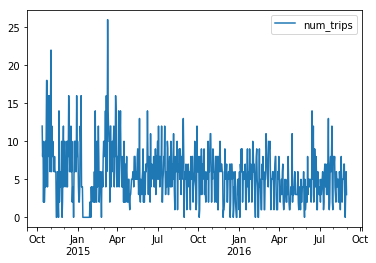

In [122]:
trips_by_date_2.plot(y='num_trips');

In this particular case, differences in computed stats, while not huge, are certainly present. Taking zero days into account along with carefully specifying the analysis period of interest are both important in computing temporal statistics such averages and percentiles of number of trips per day.

In Part 2 of this post, we'll extend this to cases in which we might want to group by an additional field (e.g. station_id) and see how this problem is just one part of the general problem of doing occupancy analysis based on transaction data. We'll see how the [hillmaker](https://github.com/misken/hillmaker) package can make these types of analyses easier. 